In [ ]:

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from gym import logger as gymlogger
gymlogger.set_level(40)  # error only

import random
import math


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device : {}".format(device))


device : cpu


In [11]:
# Acrobot-v1: state_dim = 6, action_dim = 3
class ActorNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.hidden = nn.Linear(6, hidden_dim)
        self.output = nn.Linear(hidden_dim, 3)

    def forward(self, s):
        x = torch.tanh(self.hidden(s))
        logits = self.output(x)
        return logits

class ValueNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.hidden = nn.Linear(6, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        x = torch.tanh(self.hidden(s))
        value = self.output(x)
        return value

actor_func = ActorNet().to(device)
value_func = ValueNet().to(device)

gamma = 0.99

In [12]:
# pick up action with above distribution policy_pi
def pick_sample(s):
    with torch.no_grad():
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        logits = actor_func(s_batch).squeeze(dim=0)
        probs = F.softmax(logits, dim=-1)
        a = torch.multinomial(probs, num_samples=1)
        return a.item()


In [13]:
env = gym.make("Acrobot-v1")
reward_records = []
output_weights_history = []


In [14]:
opt1 = torch.optim.AdamW(value_func.parameters(), lr=0.001)
opt2 = torch.optim.AdamW(actor_func.parameters(), lr=0.001)


In [48]:
for i in range(3000):
    done = False
    states = []
    actions = []
    rewards = []
    s, _ = env.reset()


    while not done:
        states.append(s.tolist())
        a = pick_sample(s)
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        actions.append(a)
        rewards.append(r)
    print(i, end=", ")

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [ ]:
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        logits = self.net(x)
        probs = F.softmax(logits, dim=-1) 
        return probs


In [51]:
output_weights_history.append(params[-2].detach().cpu().numpy().flatten())


In [52]:
# Get cumulative rewards
cum_rewards = np.zeros_like(rewards, dtype=np.float32)
reward_len = len(rewards)
for j in reversed(range(reward_len)):
    cum_rewards[j] = rewards[j] + (gamma * cum_rewards[j+1] if j+1 < reward_len else 0)


In [53]:
# Optimize value loss (Critic)
opt1.zero_grad()
states_tensor = torch.tensor(states, dtype=torch.float).to(device)
cum_rewards_tensor = torch.tensor(cum_rewards, dtype=torch.float).to(device)
values = value_func(states_tensor).squeeze(dim=1)
vf_loss = F.mse_loss(values, cum_rewards_tensor, reduction="none")
vf_loss.sum().backward()
opt1.step()



In [54]:
# Optimize policy loss (Actor)
with torch.no_grad():
    values = value_func(states_tensor)

opt2.zero_grad()
actions_tensor = torch.tensor(actions, dtype=torch.int64).to(device)
advantages = cum_rewards_tensor - values.squeeze(dim=1)
logits = actor_func(states_tensor)
log_probs = -F.cross_entropy(logits, actions_tensor, reduction="none")
pi_loss = -log_probs * advantages
pi_loss.sum().backward()
opt2.step()


In [55]:
# Output total rewards in episode
print("Run episode {} with rewards {}".format(i, sum(rewards)), end="\r")
reward_records.append(sum(rewards))

# Store output weights
params = list(actor_func.parameters())
output_weights_history.append(params[-2].detach().cpu().numpy().flatten())


In [ ]:
output_weights_history = []

for i in range(3000):
    done = False
    states = []
    actions = []
    rewards = []

    s, _ = env.reset()

    # Episode loop
    while not done:
        state_tensor = torch.tensor(s, dtype=torch.float32)
        action_probs = actor_func(state_tensor)

        # Convert to valid distribution
        action_probs = torch.softmax(action_probs, dim=0)  
        dist = torch.distributions.Categorical(action_probs)
        a = dist.sample()

        states.append(state_tensor)
        actions.append(a)
        s, r, term, trunc, _ = env.step(a.item())
        done = term or trunc
        rewards.append(r)

    # Compute returns (discounted rewards)
    G = 0
    gamma = 0.99
    returns = []
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns, dtype=torch.float32)

    # Normalize returns (optional but helps)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    # Actor loss (REINFORCE-style)
    opt1.zero_grad()
    loss1 = 0
    for j in range(len(states)):
        action_probs = actor_func(states[j])
        action_probs = torch.softmax(action_probs, dim=0)  
        dist = torch.distributions.Categorical(action_probs)
        log_prob = dist.log_prob(actions[j])
        loss1 += -log_prob * returns[j]  # gradient ascent

    loss1.backward()
    opt1.step()

    # Save output layer weights (usually last linear layer)
    with torch.no_grad():
        params = list(actor_func.parameters())
        output_weights_history.append(params[-2].detach().cpu().numpy().flatten())

    # Optional progress
    if i % 100 == 0:
        print(f"Episode {i} completed.")


Episode 0 completed.
Episode 100 completed.
Episode 200 completed.
Episode 300 completed.
Episode 400 completed.
Episode 500 completed.
Episode 600 completed.
Episode 700 completed.
Episode 800 completed.
Episode 900 completed.
Episode 1000 completed.
Episode 1100 completed.
Episode 1200 completed.
Episode 1300 completed.
Episode 1400 completed.
Episode 1500 completed.
Episode 1600 completed.
Episode 1700 completed.
Episode 1800 completed.
Episode 1900 completed.
Episode 2000 completed.
Episode 2100 completed.
Episode 2200 completed.
Episode 2300 completed.
Episode 2400 completed.
Episode 2500 completed.
Episode 2600 completed.
Episode 2700 completed.
Episode 2800 completed.
Episode 2900 completed.


In [61]:
# Compare change in output layer weights
if len(output_weights_history) > 1:
    last = output_weights_history[-1]
    prev = output_weights_history[-2]
    delta = np.abs(last - prev).max()
    print(f"[{i}] Max weight change:", delta)


[47] Max weight change: 0.0


In [62]:
opt1 = torch.optim.Adam(actor_func.parameters(), lr=0.01)  # or even 0.05


In [63]:
import torch.nn as nn

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)  # output logits
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
actor_func = Actor(state_dim=2, action_dim=3) 


In [7]:
pip install renderlab


Run episode1499 with rewards -100.0
Done
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


  plt.tight_layout()



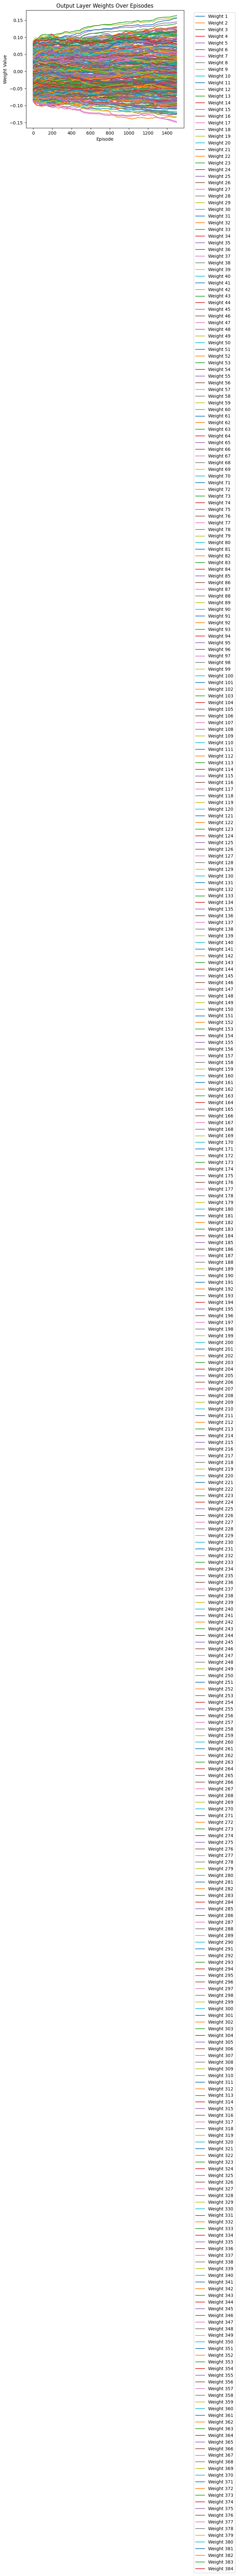

In [ ]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import renderlab as rl
import imageio
import os
os.makedirs("output", exist_ok=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Actor network
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
           nn.Linear(6, 128),
            nn.ReLU(),
            nn.Linear(128, 3)  
        )

    def forward(self, x):
        return self.net(x)

# Define Critic network
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
         nn.Sequential(
    nn.Linear(6, 128),  # Input layer for 6-dimensional state
    nn.ReLU(),
    nn.Linear(128, 1)   # Output layer for 3 actions
)

        )

    def forward(self, x):
        return self.net(x)

# Action selection
def pick_sample(s):
    with torch.no_grad():
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        logits = actor_func(s_batch).squeeze(0)
        probs = F.softmax(logits, dim=-1)
        a = torch.multinomial(probs, num_samples=1)
        return a.item()

# Initialize environment with render wrapper
# assuming your rl.RenderFrame is here
env = gym.make("Acrobot-v1", render_mode="rgb_array")


env = rl.RenderFrame(env, "./output")

# Initialize models and optimizers
actor_func = Actor().to(device)
value_func = Critic().to(device)
opt1 = torch.optim.AdamW(value_func.parameters(), lr=0.001)
opt2 = torch.optim.AdamW(actor_func.parameters(), lr=0.001)

gamma = 0.99
reward_records = []
output_weights_history = []

for i in range(1500):
    done = False
    states = []
    actions = []
    rewards = []
    s, _ = env.reset()

    while not done:
        states.append(s.tolist())
        a = pick_sample(s)
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        actions.append(a)
        rewards.append(r)

    # Calculate cumulative rewards
    cum_rewards = np.zeros_like(rewards, dtype=np.float32)
    for j in reversed(range(len(rewards))):
        cum_rewards[j] = rewards[j] + (gamma * cum_rewards[j+1] if j + 1 < len(rewards) else 0)

    # Critic optimization
    opt1.zero_grad()
    states_tensor = torch.tensor(states, dtype=torch.float32).to(device)
    rewards_tensor = torch.tensor(cum_rewards, dtype=torch.float32).to(device)
    values = value_func(states_tensor).squeeze(1)
    vf_loss = F.mse_loss(values, rewards_tensor, reduction="none")
    vf_loss.sum().backward()
    opt1.step()

    # Actor optimization
    with torch.no_grad():
        values = value_func(states_tensor).squeeze(1)
    opt2.zero_grad()
    actions_tensor = torch.tensor(actions, dtype=torch.int64).to(device)
    advantages = rewards_tensor - values
    logits = actor_func(states_tensor)
    log_probs = -F.cross_entropy(logits, actions_tensor, reduction="none")
    pi_loss = -log_probs * advantages
    pi_loss.sum().backward()
    opt2.step()

    reward_records.append(sum(rewards))
    print(f"Run episode{i} with rewards {sum(rewards)}", end="\r")

    # Track output layer weights correctly (use last layer)
    output_weights_history.append(actor_func.net[-1].weight.detach().cpu().numpy().flatten())

    if np.mean(reward_records[-50:]) > 475.0:
        break

print("\nDone")

# Play recorded video
env.play()
env.close()

# Plot output layer weights over episodes
episodes = list(range(0, len(output_weights_history)))
num_weights = len(output_weights_history[0])

for i in range(num_weights):
    plt.plot(episodes, [w[i] for w in output_weights_history], label=f'Weight {i+1}')

plt.xlabel('Episode')
plt.ylabel('Weight Value')
plt.title('Output Layer Weights Over Episodes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


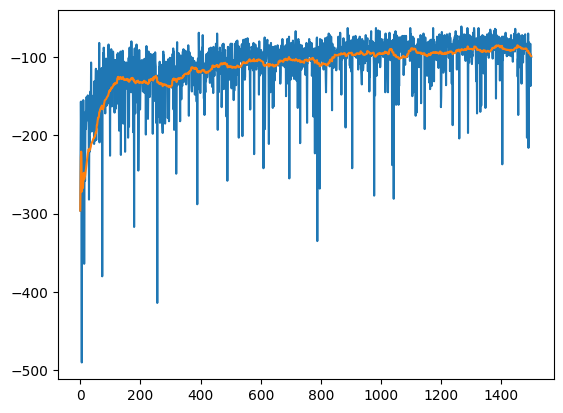

In [16]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)